* Look at extrapolation beyond the edge of the image - what does the model think is out there? Is uncertainty higher?
* Maybe we could think of each data set that we have (May, Dec, Apr) as being a separate "image" that we then pick a context from and train on predicting targets. What could we learn from this?
* From [Kaspar's blog post][kaspar], how the uncertainty is quite low when the NP is failing to extrapolate to abs(sin(x)) and 2.5 * sin(x) - is there something we could change to make the uncertainty higher when the given context points are very different (at least, taken together) than those in training?
  * See how a GP would do on similar tasks? But my GP will probably be sub-optimal because I don't know all the GP tricks...
* [Face completion][face completion]

[kaspar]: http://kasparmartens.rbind.io/post/np/
[face completion]: http://scikit-learn.org/stable/auto_examples/plot_multioutput_face_completion.html#sphx-glr-auto-examples-plot-multioutput-face-completion-py

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Callable

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

device = torch.device('cuda:0' if torch.has_cudnn else 'cpu')
pyro.enable_validation(True)
%matplotlib inline

In [2]:
data_dir = '../data'
train_set = MNIST(data_dir, train=True, transform=transforms.ToTensor())
train_imgs = train_set.train_data.float() / 255

test_set = MNIST(data_dir, train=False, transform=transforms.ToTensor())
test_imgs = test_set.test_data.float() / 255

In [3]:
x_dim = 2
y_dim = 1
learning_rate = 1e-3
hidden_dim = 128
r_dim = 128
z_dim = 128

# the pixel locations are the same for all images
width, height = train_imgs.shape[1:3]
x = torch.tensor([[i / (height - 1), j / (width - 1)] for i in range(height) for j in range(width)])
x = x.to(device)

shuffle_idx = list(range(len(x)))

In [4]:
# f(x_C, y_C) = r
class Representer(nn.Module):
    def __init__(self, x_y_dim, hidden_dim, r_dim):
        super().__init__()

        self.fc1 = nn.Linear(x_y_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, r_dim)
#         self.r = torch.zeros(r_dim)

        self.softplus = nn.Softplus()

    def forward(self, x_y):
        hidden = self.softplus(self.fc1(x_y))
        hidden = self.softplus(self.fc2(hidden))
        hidden = self.softplus(self.fc3(hidden))
        r_i = self.fc4(hidden)
        return r_i.mean(dim=0)

In [5]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|r)
class Encoder(nn.Module):
    def __init__(self, r_dim, hidden_dim, z_dim):
        super().__init__()

        self.fc1 = nn.Linear(r_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)

        self.softplus = nn.Softplus()

    def forward(self, r):
        hidden = self.softplus(self.fc1(r))
        z_loc = self.fc21(hidden)
        z_scale = self.softplus(self.fc22(hidden))
        return z_loc, z_scale

In [6]:
# y_mean = f(z, x)
class Decoder(nn.Module):
    def __init__(self, z_x_dim, hidden_dim, output_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_x_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc61 = nn.Linear(hidden_dim, output_dim)
        self.fc62 = nn.Linear(hidden_dim, output_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z_x):
        hidden = self.softplus(self.fc1(z_x))
        hidden = self.softplus(self.fc2(hidden))
        alpha = self.fc31(hidden)
        beta = self.fc32(hidden)
        
        alpha.clamp_(.01)
        beta.clamp_(.01)
        
        return alpha, beta

In [7]:
# y_mean = f(z, x)
class Decoder(nn.Module):
    def __init__(self, z_x_dim, hidden_dim, output_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_x_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, output_dim)

        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z_x):
        hidden = self.softplus(self.fc1(z_x))
        hidden = self.softplus(self.fc2(hidden))
        hidden = self.softplus(self.fc3(hidden))
        hidden = self.softplus(self.fc4(hidden))
        hidden = self.softplus(self.fc5(hidden))
        y_mean = self.fc6(hidden)
        return y_mean

In [8]:
# y_mean = f(z, x)
class Decoder_CNP(nn.Module):
    def __init__(self, r_x_dim, hidden_dim, output_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(r_x_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc51 = nn.Linear(hidden_dim, output_dim)
        self.fc52 = nn.Linear(hidden_dim, output_dim)

        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, r_x):
        hidden = self.softplus(self.fc1(r_x))
        hidden = self.softplus(self.fc2(hidden))
        hidden = self.softplus(self.fc3(hidden))
        hidden = self.softplus(self.fc4(hidden))
        y_mean = self.fc51(hidden)
        y_std = torch.exp(self.fc52(hidden))
        return y_mean, y_std

In [9]:
def plot_samples(model: Callable[[int, torch.Tensor, torch.Tensor], torch.Tensor], n_contexts: Tuple[int]=(10, 100, 300, 784), n_preds: int=3):
    img_idx = np.random.randint(len(test_imgs))
    y = test_imgs[img_idx].reshape(-1, 1).to(device)

    np.random.shuffle(shuffle_idx)
    unshuffle_idx = np.argsort(shuffle_idx)

    fig, subplots = plt.subplots(figsize=(10, 10), nrows=n_preds + 1, ncols=len(n_contexts))

    # n_context = np.random.randint(1, len(x) // 2)
    for (context_i, n_context) in enumerate(n_contexts):
        subplots[0, context_i].imshow(test_imgs[img_idx], cmap='Greys')
        subplots[0, context_i].axis('off')
        subplots[0, context_i].set_title(f'{n_context} context')

        for i in range(n_preds):
            pred = model(n_context, x[shuffle_idx], y[shuffle_idx])

            try:
                pred = pred.detach()
            except AttributeError:  # not a torch.Tensor
                pass
#             return pred[unshuffle_idx]#.view((width, height, 1)).expand(-1, -1, 3)
            subplots[i + 1, context_i].imshow(pred[unshuffle_idx].view((width, height, 1)).expand(-1, -1, 3))
#             subplots[i + 1, context_i].imshow(pred[unshuffle_idx].reshape(width, height), cmap='Greys')
            subplots[i + 1, context_i].axis('off')

# KNN

In [9]:
from sklearn.neighbors import KNeighborsRegressor

def knn_model(n_context, x, y, k: int=3):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x[:n_context], y[:n_context])
    return knn.predict(x)

TypeError: data type not understood

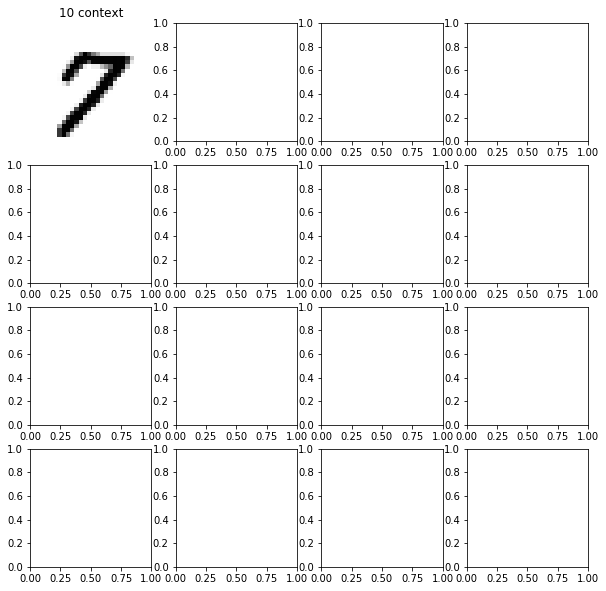

In [10]:
q = plot_samples(knn_model)

# CNP regressing GP

$$
r_i = h_\theta(x_i, y_i) \forall (x_i, y_i) \in O \\
r = r_1 \bigoplus \dots \bigoplus r_n \\
\phi_i = q_\theta(x_i, r) \forall x_i \in T
$$

where $h$ and $q$ are learned functions (e.g. neural networks).

Matching networks (Vinyals 2016; Bartunov 2016) seem like they might do Sid's attention idea?
* Normal scaling is O(nm); Snell, 2017 modifies to do O(n + m) (not sure how)

In [2]:
n_inputs = 1
n_hidden = 128
representation_size = 128
non_linearity = 'ReLU'

representer = nn.Sequential(
    nn.Linear(n_inputs, n_hidden),
    getattr(nn, non_linearity)(),
    nn.Linear(n_hidden, n_hidden),
    getattr(nn, non_linearity)(),
    nn.Linear(n_hidden, representation_size)
).to(device)

In [41]:
import pyro
from pyro.distributions import MultivariateNormal
from pyro.contrib import gp

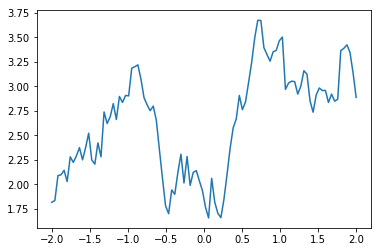

In [93]:
variance = 5.0
lengthscale = 10.0

x = torch.linspace(-2, 2, 100)

kernel = gp.kernels.Exponential(n_inputs, torch.tensor(variance), torch.tensor(lengthscale))

cov = kernel.forward(x)

y = MultivariateNormal(torch.zeros(len(cov)), cov).sample((1,))

plt.plot(x.numpy()[:, None], y.numpy().T);

# NP

* I'm assuming that we use a NN to parametrize $\mu(r), \sigma(r)$.

Questions
* $g(x_T, z)$ is deterministic, right? So then $p(y_T | x_T, z) = 1$ for the single value $y_T = g(x_T, z)$ and zero for all others; all of the randomness is in $z$. Maybe I should add a little noise in so that there's some probability for other values. Say, $p(y_T | x_T, z) \sim \mathcal N(g(x_T, z), \sigma^2)$

## Deterministic Version

In [ ]:
# predicting on _all_ points, not just the target ones

In [80]:
class DP(nn.Module):
    def __init__(self, x_dim: int, y_dim: int, hidden_dim: int=128, r_dim: int=256, z_dim: int=128):
        super().__init__()
        self.representer = Representer(x_dim + y_dim, hidden_dim, r_dim)
        self.decoder = Decoder(r_dim + x_dim, hidden_dim, y_dim)
    
    def forward(self, n_context, x, y, predict: bool=False):
        y_scale = .01

        x_context = x[:n_context]
        y_context = y[:n_context]

        # the prior is q(z|x_C, y_C)
        r = self.representer.forward(torch.cat((x_context, y_context), dim=1))
        y_pred = self.decoder.forward(torch.cat((r.expand(len(x), -1), x), dim=1))
        return y_pred

In [115]:
loss_op = nn.MSELoss()
dp = DP(x_dim, y_dim, hidden_dim, r_dim, z_dim).to(device)
optimizer = torch.optim.Adam(dp.parameters())

In [116]:
n_steps = 3 * len(train_imgs)

losses = []
for step in range(n_steps):
    img_idx = np.random.randint(len(train_imgs))

    y = train_imgs[img_idx].reshape(-1, 1).to(device)

    np.random.shuffle(shuffle_idx)
    n_context = np.random.randint(1, len(x) // 2)

    optimizer.zero_grad()
    
    y_fake = 2 * x.mean(dim=1, keepdim=True) + 3
    y_pred = dp(n_context, x[shuffle_idx], y_fake)
    loss = loss_op(y_pred, y_fake)
    
#     y_pred = dp(n_context, x[shuffle_idx], y[shuffle_idx])
#     loss = loss_op(y_pred, y[shuffle_idx])

    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if step % 1000 == 0:
        print(f"{step}: {np.mean(losses[-1000:]):.4f}")

0: 12.7227
1000: 9.1808
2000: 9.1790
3000: 9.1790
4000: 9.1790
5000: 9.1790
6000: 9.1790
7000: 9.1790
8000: 9.1790
9000: 9.1790
10000: 9.1790
11000: 9.1790
12000: 9.1790
13000: 9.1790
14000: 9.1790
15000: 9.1790
16000: 9.1790
17000: 9.1790
18000: 9.1790
19000: 9.1790
20000: 9.1790
21000: 9.1790
22000: 9.1790
23000: 9.1790
24000: 9.1790
25000: 9.1790
26000: 9.1790
27000: 9.1790
28000: 9.1790
29000: 9.1790
30000: 9.1790
31000: 9.1790
32000: 9.1790
33000: 9.1790
34000: 9.1790
35000: 9.1790
36000: 9.1790
37000: 9.1790
38000: 9.1790
39000: 9.1790
40000: 9.1790
41000: 9.1790
42000: 9.1790
43000: 9.1790
44000: 9.1790
45000: 9.1790
46000: 9.1790
47000: 9.1790
48000: 9.1790
49000: 9.1790
50000: 9.1790
51000: 9.1790
52000: 9.1790
53000: 9.1790
54000: 9.1790
55000: 9.1790
56000: 9.1790
57000: 9.1790
58000: 9.1790
59000: 9.1790
60000: 9.1790
61000: 9.1790
62000: 9.1790
63000: 9.1790
64000: 9.1790
65000: 9.1790
66000: 9.1790
67000: 9.1790
68000: 9.1790
69000: 9.1790
70000: 9.1790
71000: 9.1790
7200

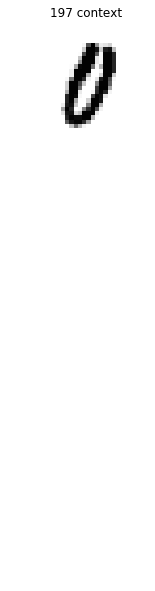

In [102]:
n_preds = 3

img_idx = np.random.randint(len(test_imgs))
y = test_imgs[img_idx].reshape(-1, 1).to(device)

np.random.shuffle(shuffle_idx)
n_context = np.random.randint(1, len(x) // 2)

plt.figure(figsize=(5, 10))

plt.subplot(n_preds + 1, 1, 1)
plt.imshow(test_imgs[img_idx], cmap='Greys')
plt.axis('off')
plt.title(f'{n_context} context')

for i in range(n_preds):
    pred = dp(n_context, x[shuffle_idx], y[shuffle_idx])

    plt.subplot(n_preds + 1, 1, i + 2)
    plt.imshow(pred.reshape(width, height).detach(), cmap='Greys')
    plt.axis('off')

## CNP

In [10]:
class CNP(nn.Module):
    def __init__(self, x_dim: int, y_dim: int, hidden_dim: int=128, r_dim: int=256, z_dim: int=128):
        super().__init__()

        self.representer = Representer(x_dim + y_dim, hidden_dim, r_dim)
        self.decoder = Decoder_CNP(r_dim + x_dim, hidden_dim, y_dim)

    def forward(self, n_context, x, y):
        x_context = x[:n_context]
        y_context = y[:n_context]

        r = self.representer.forward(torch.cat((x_context, y_context), dim=1))
        y_mean, y_std = self.decoder.forward(torch.cat((r.expand(len(x), -1), x), dim=1))
        return y_mean, y_std

In [27]:
loss_op = nn.MSELoss()
cnp = CNP(x_dim, y_dim, hidden_dim, r_dim, z_dim).to(device)
losses = []
optimizer = torch.optim.Adam(cnp.parameters())

In [12]:
n_steps = 3 * len(train_imgs)

for step in range(n_steps):
    optimizer.zero_grad()

    img_idx = np.random.randint(len(train_imgs))
    y = train_imgs[img_idx].reshape(-1, 1).to(device)
    np.random.shuffle(shuffle_idx)

    n_context = np.random.randint(1, len(x) // 2)
    y_mean, y_std = cnp(n_context, x[shuffle_idx], y[shuffle_idx])

    loss = -torch.distributions.Normal(y_mean, y_std).log_prob(y[shuffle_idx]).sum() / len(x)

    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if step % 1000 == 0:
        print(f"{step}: {np.mean(losses[-1000:]):.4f}")

0: 1.3594
1000: 0.2568
2000: 0.2586
3000: 0.2482
4000: 0.2440
5000: 0.2425
6000: 0.2411
7000: 0.2462
8000: 0.2449
9000: 0.0644
10000: -0.1533
11000: -0.2199
12000: -0.1327
13000: -0.1437
14000: -0.2403
15000: -0.2611
16000: -0.2286
17000: -0.1331
18000: -0.1593
19000: -0.1902
20000: -0.0548
21000: -0.1376
22000: -0.1769
23000: -0.2060
24000: -0.2970
25000: -0.1242
26000: -0.3284
27000: 0.1121
28000: 0.0506
29000: -0.2075
30000: -0.2644
31000: -0.3368
32000: -0.3194
33000: -0.3343
34000: -0.3127
35000: -0.3311
36000: 0.0711
37000: -0.2380
38000: -0.1922
39000: -0.2786
40000: -0.1407
41000: -0.2712
42000: -0.0727
43000: -0.2776
44000: 0.0252
45000: -0.2821
46000: -0.2539
47000: -0.1466
48000: -0.3177
49000: -0.2797
50000: -0.0356
51000: -0.0134
52000: -0.2885
53000: -0.1058
54000: -0.2475
55000: 0.1325
56000: -0.1867
57000: -0.1293
58000: 0.0177
59000: -0.0467
60000: -0.0644
61000: -0.2791
62000: -0.2238
63000: -0.2128
64000: -0.2405
65000: -0.2612
66000: -0.1294
67000: -0.0456
68000: -0

In [ ]:
n_steps = 3 * len(train_imgs)
n_img_samples = 16
n_context_samples = 10

for step in range(n_steps):
    optimizer.zero_grad()
    step_loss = torch.tensor(0.).to(device)

    for _ in range(n_img_samples):
        img_idx = np.random.randint(len(train_imgs))
        y = train_imgs[img_idx].reshape(-1, 1).to(device)
        np.random.shuffle(shuffle_idx)

        img_loss = torch.tensor(0.).to(device)
        for _ in range(n_context_samples):
            n_context = np.random.randint(1, len(x) // 2)
            y_mean, y_std = cnp(n_context, x[shuffle_idx], y[shuffle_idx])

            prob = -torch.distributions.Normal(y_mean, y_std).log_prob(y[shuffle_idx]).sum() / len(x)
            img_loss += prob / n_context_samples
        
        step_loss += img_loss / n_img_samples

    step_loss.backward()
    optimizer.step()

    losses.append(step_loss.item())
    if step % 100 == 0:
        print(f"{step}: {np.mean(losses[-100:]):.4f}")

0: 0.9273
100: 0.2549
200: 0.2391
300: 0.2385
400: 0.2423
500: 0.2466
600: 0.2447
700: 0.2430
800: 0.2378
900: 0.2237
1300: 0.1825
1400: 0.2277
1500: 0.2439
1600: 0.2317
1700: 0.2173
1800: 0.2535
1900: 0.2427
2000: 0.2444
2100: 0.2419
2200: 0.2421
2300: 0.2444
2400: 0.2464
2500: 0.2454
2600: 0.2365
2700: 0.2469
2800: 0.2422
2900: 0.2450
3000: 0.2404
3100: 0.2376
3200: 0.2455
3300: 0.2406
3400: 0.2460
3500: 0.2406
3600: 0.2494
3700: 0.2469
3800: 0.2431
3900: 0.2426
4000: 0.2438
4100: 0.2407
4200: 0.2435
4300: 0.2477
4400: 0.2448
4500: 0.2488
4600: 0.2468
4700: 0.2417
4800: 0.2414
4900: 0.2500
5000: 0.2496
5100: 0.2455
5200: 0.2468
5300: 0.2410
5400: 0.2469
5500: 0.2428
5600: 0.2398
5700: 0.2487
5800: 0.2424
5900: 0.2513


In [27]:
n_steps = 3 * len(train_imgs)

losses = []
for step in range(n_steps):
    img_idx = np.random.randint(len(train_imgs))

    y = train_imgs[img_idx].reshape(-1, 1).to(device)

    np.random.shuffle(shuffle_idx)
    n_context = np.random.randint(1, len(x) // 2)

    optimizer.zero_grad()

    y_mean, y_std = cnp(n_context, x[shuffle_idx], y[shuffle_idx])
    
    loss = loss_op(y_mean, y[shuffle_idx])

    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if step % 1000 == 0:
        print(f"{step}: {np.mean(losses[-1000:]):.4f}")

0: 0.2750
1000: 0.0991
2000: 0.0991
3000: 0.0959
4000: 0.0965
5000: 0.0986
6000: 0.1004
7000: 0.0986
8000: 0.0969
9000: 0.0970
10000: 0.0971
11000: 0.0989
12000: 0.0972
13000: 0.0968
14000: 0.0964
15000: 0.0965
16000: 0.0974
17000: 0.0960
18000: 0.0974
19000: 0.0956
20000: 0.0975
21000: 0.0961
22000: 0.0968
23000: 0.0979
24000: 0.0968
25000: 0.0976
26000: 0.0981
27000: 0.0957
28000: 0.0979
29000: 0.0976
30000: 0.0967
31000: 0.0954
32000: 0.0980
33000: 0.0982
34000: 0.0971
35000: 0.0963
36000: 0.0949
37000: 0.0972
38000: 0.0970
39000: 0.0957
40000: 0.0978
41000: 0.0956
42000: 0.0962
43000: 0.0953
44000: 0.0951
45000: 0.0952
46000: 0.0972
47000: 0.0945
48000: 0.0965
49000: 0.0963
50000: 0.0963
51000: 0.0957
52000: 0.0963
53000: 0.0966
54000: 0.0973
55000: 0.0963
56000: 0.0974
57000: 0.0961
58000: 0.0947
59000: 0.0969
60000: 0.0976
61000: 0.0972
62000: 0.0964
63000: 0.0954
64000: 0.0959
65000: 0.0952
66000: 0.0958
67000: 0.0971
68000: 0.0958
69000: 0.0964
70000: 0.0972
71000: 0.0947
72000

KeyboardInterrupt: 

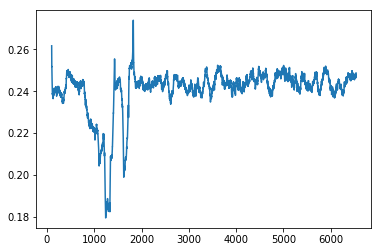

In [30]:
pd.Series(losses).rolling(window=100).mean().plot()

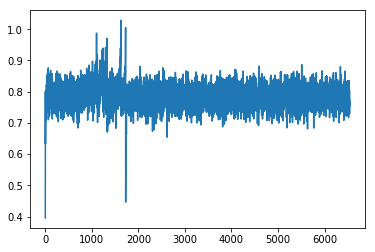

In [31]:
(np.e ** -pd.Series(losses)).plot()

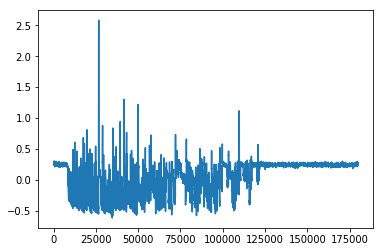

In [13]:
pd.Series(losses).rolling(window=100).mean().plot()

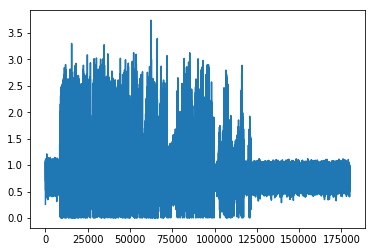

In [14]:
(np.e ** -pd.Series(losses)).plot()

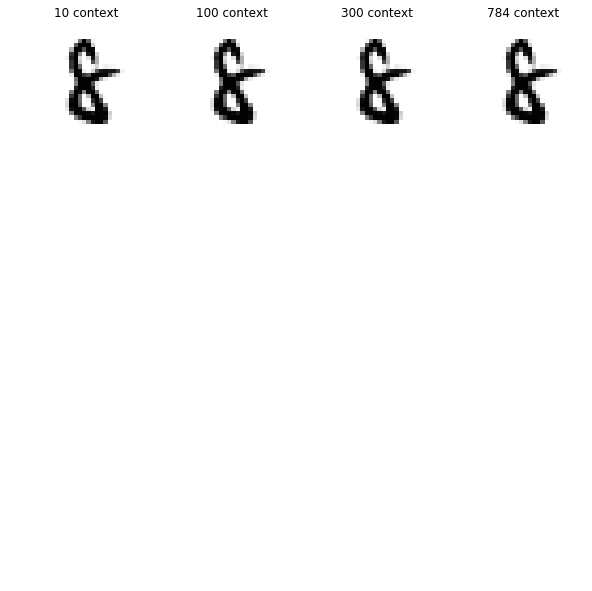

In [35]:
plot_samples(lambda *args: cnp(*args)[0])

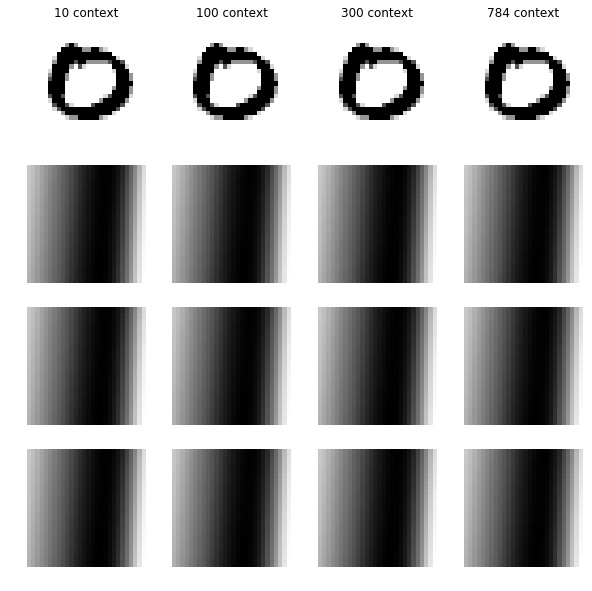

In [21]:
plot_samples(lambda *args: cnp(*args)[0])

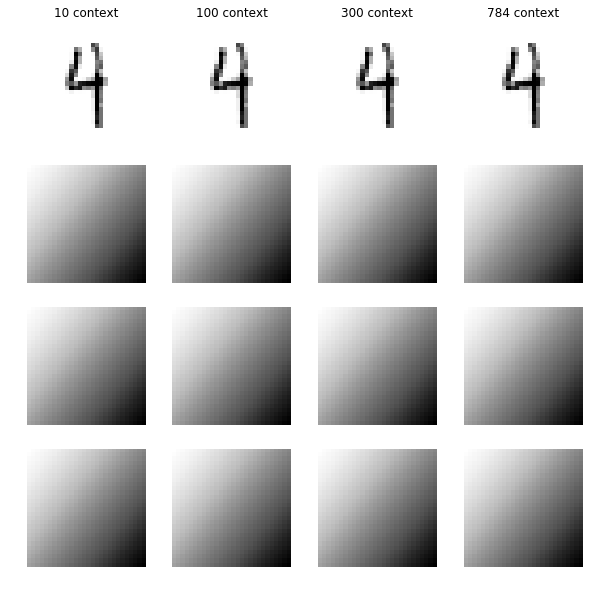

In [17]:
plot_samples(lambda *args: cnp(*args)[1])

### Pyro CNP

In [ ]:
class CNP(nn.Module):
    def __init__(self, x_dim: int, y_dim: int, hidden_dim: int=128, r_dim: int=256, z_dim: int=128):
        super().__init__()

        self.representer = Representer(x_dim + y_dim, hidden_dim, r_dim)
        self.decoder = Decoder_CNP(r_dim + x_dim, hidden_dim, 2 * y_dim)

    def model(self, n_context, x, y, predict: bool=False):
        pyro.module("representer", self.representer)
        pyro.module("decoder", self.decoder)

        x_context = x[:n_context]
        y_context = y[:n_context]

        # the prior is q(z|x_C, y_C)
        r = self.representer.forward(torch.cat((x_context, y_context), dim=1))
        y_mean, y_std = self.decoder.forward(torch.cat((r.expand(len(x), -1), x), dim=1))

        # only evaluate the target predictions against real values
        pyro.sample("obs", dist.Normal(y_mean, y_std).independent(1), obs=y)
        return y_mean, y_std

    # approximate posterior for p(z|x, y), parametrized by
    # the encoder + representer
    def guide(self, n_context, x, y, predict: bool=False):
        pyro.module("encoder", self.encoder)
        pyro.module("representer", self.representer)
        
        # for the posterior, use all of x and y
        r = self.representer.forward(torch.cat((x, y), dim=1))
        z_loc, z_scale = self.encoder.forward(r)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
        
        if predict:
            # get predictions for the whole x, including context
            with pyro.iarange("data", len(x)) as i:
                y_mean = self.decoder.forward(torch.cat((z.expand(len(x), -1), x[i]), dim=1))
                return y_mean

## Pyro NP

In [11]:
class NP(nn.Module):
    def __init__(self, x_dim: int, y_dim: int, hidden_dim: int=128, r_dim: int=256, z_dim: int=128):
        super().__init__()

        self.representer = Representer(x_dim + y_dim, hidden_dim, r_dim)
        self.encoder = Encoder(r_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim + x_dim, hidden_dim, y_dim)

    def model(self, n_context, x, y, predict: bool=False):
        y_scale = .01

        pyro.module("representer", self.representer)
        pyro.module("encoder", self.encoder)
        pyro.module("decoder", self.decoder)

        x_context = x[:n_context]
        y_context = y[:n_context]
        x_target = x[n_context:]
        y_target = y[n_context:]

        # the prior is q(z|x_C, y_C)
        r = self.representer.forward(torch.cat((x_context, y_context), dim=1))
        z_loc, z_scale = self.encoder.forward(r)
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

        # only evaluate the target predictions against real values
        with pyro.iarange("data", len(x_target)) as i:
#             alpha, beta = self.decoder.forward(torch.cat((z.expand(len(x_target), -1), x_target[i]), dim=1))
#             pyro.sample("obs", dist.Beta(alpha, beta).independent(1), obs=y_target)
#             return alpha, beta

            y_mean = self.decoder.forward(torch.cat((z.expand(len(x_target), -1), x_target[i]), dim=1))
            pyro.sample("obs", dist.Normal(y_mean.squeeze(), y_scale), obs=y_target[i].squeeze())
            return y_mean

    # approximate posterior for p(z|x, y), parametrized by
    # the encoder + representer
    def guide(self, n_context, x, y, predict: bool=False):
        pyro.module("encoder", self.encoder)
        pyro.module("representer", self.representer)
        pyro.module("decoder", self.decoder) # need this?
        
        # for the posterior, use all of x and y
        r = self.representer.forward(torch.cat((x, y), dim=1))
        z_loc, z_scale = self.encoder.forward(r)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
        
        if predict:
            # get predictions for the whole x, including context
#             with pyro.iarange("data", len(x)) as i:
            y_mean = self.decoder.forward(torch.cat((z.expand(len(x), -1), x), dim=1))
            return y_mean

In [ ]:
n_samples = 1000
steps_per_print = 10

nprocess = NP(x_dim, y_dim, hidden_dim, r_dim, z_dim).to(device)

pyro.clear_param_store()
optimizer = Adam({"lr": learning_rate})
svi = SVI(nprocess.model, nprocess.guide, optimizer, loss=Trace_ELBO(n_samples))

n_steps = 3 * len(train_imgs)

elbos = []

In [ ]:
for step in range(n_steps):
    img_idx = np.random.randint(len(train_imgs))

    y = train_imgs[img_idx].reshape(-1, 1).to(device)

    np.random.shuffle(shuffle_idx)
    n_context = np.random.randint(1, len(x) - 1)

    elbo = svi.step(n_context, x[shuffle_idx], y[shuffle_idx])
    elbos.append(elbo)
    if step % steps_per_print == 0:
        print(f"{step}: {np.mean(elbos[-steps_per_print:]):,.0f}")

0: 155,285
10: 298,995
20: 185,918
30: 142,085
40: 303,303
50: 209,807
60: 227,509
70: 253,328
80: 133,847
90: 282,435
100: 194,430
110: 181,626
120: 245,281
130: 178,462
140: 133,874
150: 206,436
160: 227,581
170: 250,771
180: 217,624
190: 225,339
200: 96,021
210: 210,531
220: 154,394
230: 222,915
240: 185,245
250: 114,035
260: 224,932
270: 265,978
280: 93,350
290: 132,257
300: 159,776
310: 197,886
320: 196,483
330: 143,891
340: 202,770
350: 225,909
360: 161,781
370: 109,655
380: 193,393
390: 200,841
400: 155,157
450: 164,318
460: 142,558
470: 281,030
480: 184,442
490: 176,759
500: 236,768
510: 262,118
520: 223,802
530: 266,835
540: 225,182
550: 182,570
560: 204,975
570: 188,789
580: 155,008
590: 183,061
600: 224,810
610: 241,113
620: 264,147
630: 197,304
640: 160,807
650: 169,098
660: 217,884
670: 147,608


KeyboardInterrupt: 

In [ ]:
pd.Series(elbos).rolling(window=1).mean().plot()

In [23]:
def plot_samples(model: Callable[[int, torch.Tensor, torch.Tensor], torch.Tensor], n_contexts: Tuple[int]=(10, 100, 300, 784), n_preds: int=3):
    img_idx = np.random.randint(len(test_imgs))
    y = test_imgs[img_idx].reshape(-1, 1).to(device)

    np.random.shuffle(shuffle_idx)
    unshuffle_idx = np.argsort(shuffle_idx)

    fig, subplots = plt.subplots(figsize=(10, 10), nrows=n_preds + 1, ncols=len(n_contexts))

    # n_context = np.random.randint(1, len(x) // 2)
    for (context_i, n_context) in enumerate(n_contexts):
        subplots[0, context_i].imshow(test_imgs[img_idx], cmap='Greys')
        subplots[0, context_i].axis('off')
        subplots[0, context_i].set_title(f'{n_context} context')

        for i in range(n_preds):
            pred = model(n_context, x[shuffle_idx], y[shuffle_idx])

            try:
                pred = pred.detach()
            except AttributeError:  # not a torch.Tensor
                pass
#             return pred[unshuffle_idx]#.view((width, height, 1)).expand(-1, -1, 3)
            subplots[i + 1, context_i].imshow(pred[unshuffle_idx].view((width, height, 1)).expand(-1, -1, 3))
#             subplots[i + 1, context_i].imshow(pred[unshuffle_idx].reshape(width, height), cmap='Greys')
            subplots[i + 1, context_i].axis('off')

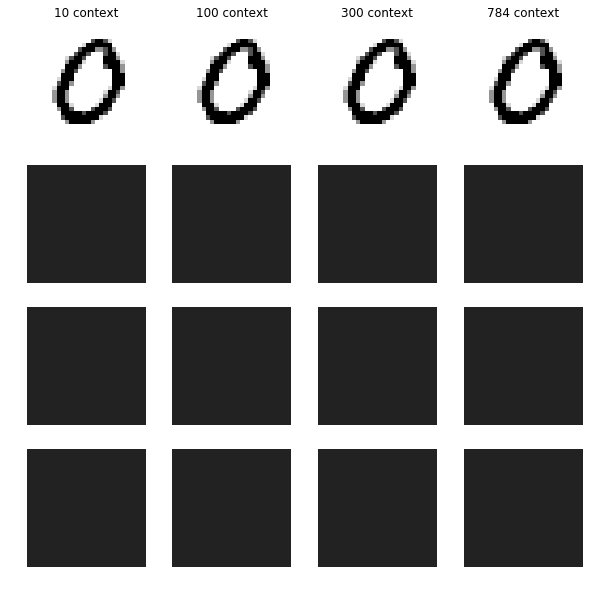

In [26]:
plot_samples(lambda *args: nprocess.guide(*args, predict=True))

In [53]:
img_idx = np.random.randint(len(test_imgs))
y = test_imgs[img_idx].reshape(-1, 1).to(device)

np.random.shuffle(shuffle_idx)
unshuffle_idx = np.argsort(shuffle_idx)

fig, subplots = plt.subplots(figsize=(10, 10), nrows=n_preds + 1, ncols=len(n_contexts))

# n_context = np.random.randint(1, len(x) // 2)
for (context_i, n_context) in enumerate(n_contexts):
    subplots[0, context_i].imshow(test_imgs[img_idx], cmap='Greys')
    subplots[0, context_i].axis('off')
    subplots[0, context_i].set_title(f'{n_context} context')

    for i in range(n_preds):
        pred = model(n_context, x[shuffle_idx], y[shuffle_idx])

        try:
            pred = pred.detach()
        except AttributeError:  # not a torch.Tensor
            pass
        return pred[unshuffle_idx]#.view((width, height, 1)).expand(-1, -1, 3)
        subplots[i + 1, context_i].imshow(pred[unshuffle_idx].view((width, height, 1)).expand(-1, -1, 3))
#             subplots[i + 1, context_i].imshow(pred[unshuffle_idx].reshape(width, height), cmap='Greys')
        subplots[i + 1, context_i].axis('off')

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorCopy.c:20

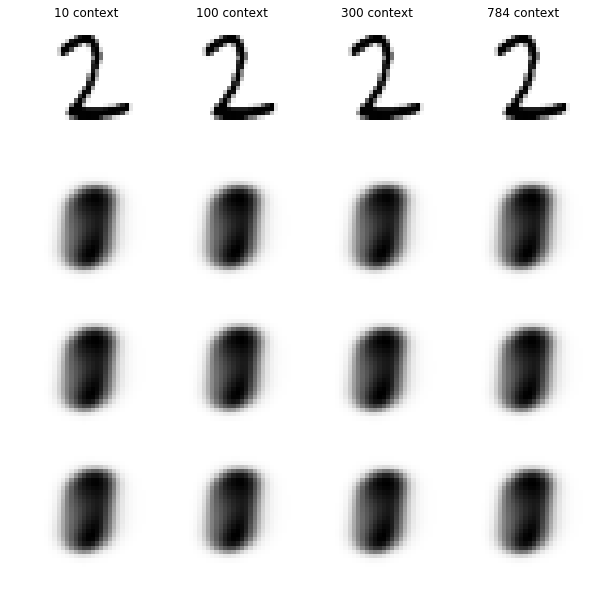

In [114]:
plot_samples(lambda *args: nprocess.guide(*args, predict=True))